In [9]:
import simdna
import simdna.synthetic as synthetic
import avutils
from avutils import util
reload(util)
import numpy as np
import momma_dragonn
reload(momma_dragonn)
import keras

%matplotlib inline
#import deepLIFT stuff
import os, sys
import numpy as np
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
import deepLIFTutils
reload(deepLIFTutils)

def sortAndPrintFilters(weights,biases):
    filterScores = np.sum((np.max(weights,axis=-2)-np.min(weights,axis=-2)),axis=-1)[:,0]
    sortedFilters = sorted(enumerate(filterScores), key=lambda x: -x[1])
    deepLIFTutils.plotPositiveAndNegativeOutlierFilters(sortedFilters=sortedFilters
                                                        , numPositiveOutliers=len(weights)
                                                        , numNegativeOutliers=0
                                                        , weights=weights
                                                        , biases=np.zeros(len(weights))
                                                        , printBias=False
                                                        , figSize=(10,2))

In [4]:
def generate_sequences_set(seq_length, num_seqs, motif_names):
    loadedMotifs = synthetic.LoadedEncodeMotifs(simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001)
    embedInBackground = synthetic.EmbedInABackground(
        backgroundGenerator=synthetic.ZeroOrderBackgroundGenerator(seqLength=seq_length)
        , embedders=[
            synthetic.RepeatedEmbedder(
            synthetic.SubstringEmbedder(
                #synthetic.ReverseComplementWrapper(
                substringGenerator=synthetic.PwmSamplerFromLoadedMotifs(
                    loadedMotifs=loadedMotifs,motifName=motifName)
                #),
                ,positionGenerator=synthetic.UniformPositionGenerator()),
            quantityGenerator=
                synthetic.ZeroInflater(
                    #synthetic.MinMaxWrapper(synthetic.PoissonQuantityGenerator(1),theMax=1, theMin=0),
                    synthetic.FixedQuantityGenerator(1),
                    zeroProb=0.9)
            )
            for motifName in motif_names
        ]
    )
    sequenceSetGenerator = synthetic.GenerateSequenceNTimes(embedInBackground, num_seqs)
    return sequenceSetGenerator

def one_hot_encode_sequences_set(sequence_set_generator):
    one_hot_encoded_sequences = []
    for sequence in sequence_set_generator.generateSequences():
        one_hot_encoded_sequences.append(avutils.util.seq_to_2d_image(sequence.seq))
    return np.array(one_hot_encoded_sequences)

seq_length=200

motif_names = ["TAL1_known1", "GATA_disc1"]

class_imbalance = 10
filters_per_motif=10

In [6]:
num_pos_train_samples = 5000
one_hot_data_train_pos = one_hot_encode_sequences_set(generate_sequences_set(seq_length=seq_length, num_seqs=num_pos_train_samples, motif_names=motif_names))
one_hot_data_train_neg = one_hot_encode_sequences_set(generate_sequences_set(seq_length=seq_length, num_seqs=num_pos_train_samples*class_imbalance, motif_names=[]))

one_hot_data_train_inputs = np.concatenate([one_hot_data_train_pos, one_hot_data_train_neg], axis=0)
one_hot_data_train_labels_reconstruction = np.concatenate([one_hot_data_train_pos, -(1.0/class_imbalance)*one_hot_data_train_neg], axis=0)
one_hot_data_train_labels_classification = np.concatenate([np.ones((len(one_hot_data_train_pos),1)), np.zeros((len(one_hot_data_train_neg),1))], axis=0)
one_hot_data_train_inputs, one_hot_data_train_labels_reconstruction, one_hot_data_train_labels_classification =\
    util.shuffle_arrays([one_hot_data_train_inputs, one_hot_data_train_labels_reconstruction, one_hot_data_train_labels_classification], copy_on_shuffle=True)

In [7]:
num_pos_valid_samples = 1000
one_hot_data_valid_pos = one_hot_encode_sequences_set(generate_sequences_set(seq_length=seq_length, num_seqs=num_pos_valid_samples, motif_names=motif_names))
one_hot_data_valid_neg = one_hot_encode_sequences_set(generate_sequences_set(seq_length=seq_length, num_seqs=num_pos_valid_samples*class_imbalance, motif_names=[]))

one_hot_data_valid_inputs = np.concatenate([one_hot_data_valid_pos, one_hot_data_valid_neg], axis=0)
one_hot_data_valid_labels_reconstruction = np.concatenate([one_hot_data_valid_pos, -(1.0/class_imbalance)*one_hot_data_valid_neg], axis=0)
one_hot_data_valid_labels_classification = np.concatenate([np.ones((len(one_hot_data_valid_pos),1)), np.zeros((len(one_hot_data_valid_neg),1))], axis=0)
one_hot_data_valid_inputs, one_hot_data_valid_labels_reconstruction, one_hot_data_valid_labels_classification =\
    util.shuffle_arrays([one_hot_data_valid_inputs, one_hot_data_valid_labels_reconstruction, one_hot_data_valid_labels_classification], copy_on_shuffle=True)

Reconstruction model

In [17]:
import keras
reload(keras)
import keras.objectives
reload(keras.backend.theano_backend)
reload(keras.objectives)
from keras import backend
reload(backend)
import keras.layers.convolutional
reload(keras.layers.convolutional)
import momma_dragonn
reload(momma_dragonn)
reload(momma_dragonn.end_of_epoch_callbacks)
reload(momma_dragonn.data_loaders)
reload(momma_dragonn.model_evaluators)
reload(momma_dragonn.model_trainers.keras_model_trainer)
reload(momma_dragonn.data_loaders.core)

def reconstruction_model_creator_func(nb_filter, pool_over_channels):
    filter_width=15
    #maxpool_filter_width=seq_length-(filter_width-1) #pool over entire region for now
    maxpool_filter_width=15
    
    from keras.models import Graph
    graph = Graph() 
    graph.add_input(name="sequence", input_shape=(1,4,seq_length))
    #add convolutional layer
    graph.add_node(
        keras.layers.convolutional.ConvDeconvSequence(
            nb_filter=nb_filter, nb_row=4, nb_col=filter_width,
            pool_over_channels=True, pool_length=maxpool_filter_width,
            W_regularizer=keras.regularizers.WeightRegularizer(l1=0.00001)),
        name="conv_deconv", input="sequence")
    #softmax across rows
    graph.add_node(
        keras.layers.convolutional.SoftmaxAcrossRows(),
        name="output_softmax", input="conv_deconv")
    #designate output node
    graph.add_output(name="output", input="output_softmax")
    #compile
    graph.compile(
        optimizer=keras.optimizers.Adam(),
        loss={"output": "one_hot_rows_categorical_cross_entropy"}
    )
    return graph

#data loaders
reconstruction_train_data_loader = momma_dragonn.data_loaders.core.BatchDataLoader_XYDictAPI(
                        X={'sequence': one_hot_data_train_inputs}, Y={'output': one_hot_data_train_labels_reconstruction},
                        weight={}, batch_size=200, num_to_load_for_eval=len(one_hot_data_valid_inputs), bundle_x_and_y_in_generator=True)
reconstruction_valid_data_loader = momma_dragonn.data_loaders.core.AtOnceDataLoader_XYDictAPI(
                        X={'sequence': one_hot_data_valid_inputs}, Y={'output': one_hot_data_valid_labels_reconstruction})
#model evaluator
reconstruction_model_evaluator = momma_dragonn.model_evaluators.GraphAccuracyStats(key_metric="onehot_rows_crossent", all_metrics=["onehot_rows_crossent"])

#trainer
reconstruction_trainer = momma_dragonn.model_trainers.keras_model_trainer.KerasFitGeneratorModelTrainer(
    samples_per_epoch=len(one_hot_data_train_inputs),
    stopping_criterion_config={"class": "EarlyStopping", "kwargs": {"max_epochs": 1000, "epochs_to_wait": 5}})

('Input modes', ['sequence'])
('Output modes', ['output'])


Using Theano backend.


In [18]:
#model creator
reconstruction_model_creator = momma_dragonn.model_creators.flexible_keras.KerasModelFromFunc(
    func=lambda: reconstruction_model_creator_func(nb_filter=filters_per_motif*len(motif_names),pool_over_channels=True),
    model_wrapper_class=momma_dragonn.model_wrappers.keras_model_wrappers.KerasGraphModelWrapper)    

#train model
reconstruction_model_wrapper, reconstruction_performance_history, reconstruction_training_metadata =\
    reconstruction_trainer.train(model_wrapper=reconstruction_model_creator.get_model_wrapper(),
                                  model_evaluator=reconstruction_model_evaluator,
                                  valid_data_loader=reconstruction_valid_data_loader,
                                  other_data_loaders={'train': reconstruction_train_data_loader},
                                  end_of_epoch_callbacks=[])
reconstruction_model = reconstruction_model_wrapper.model

Loading momma_dragonn.stopping_criteria.EarlyStopping
Loading validation data into memory
Loaded
Epoch 1/1
55000/55000 [==============================] - 44s - loss: 0.0010 - val_loss: -7.2800e-06
Epoch 1/1
55000/55000 [==============================] - 43s - loss: 3.4130e-04 - val_loss: -9.6991e-06
Epoch 1/1
55000/55000 [==============================] - 44s - loss: 1.6166e-04 - val_loss: -2.9165e-05
Epoch 1/1
55000/55000 [==============================] - 44s - loss: 8.4342e-05 - val_loss: -4.9316e-05
Epoch 1/1
55000/55000 [==============================] - 45s - loss: 5.3734e-05 - val_loss: -5.6413e-05
Epoch 1/1
55000/55000 [==============================] - 45s - loss: 3.0603e-05 - val_loss: -6.0318e-05
Epoch 1/1
55000/55000 [==============================] - 47s - loss: 1.1747e-05 - val_loss: -6.3977e-05
Epoch 1/1
55000/55000 [==============================] - 46s - loss: 2.0167e-06 - val_loss: -7.3692e-05
Epoch 1/1
55000/55000 [==============================] - 46s - loss: -6.904

In [19]:
reconstruction_file_prefix="convdeconv_10filtpermotif_10pcTALGATA_200bp"

In [20]:
reconstruction_model_wrapper.create_files_to_save(directory="models", prefix=reconstruction_file_prefix)

In [ ]:
from keras.models import model_from_yaml                                    
reconstruction_model = model_from_yaml(open("models/"+reconstruction_file_prefix+"_modelYaml.yaml").read())
reconstruction_model.load_weights("models/"+reconstruction_file_prefix+"_modelWeights.h5")

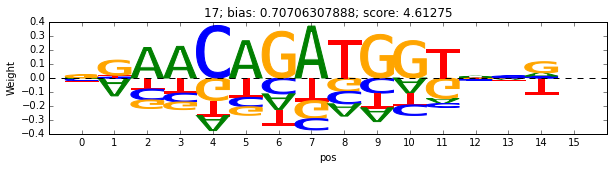

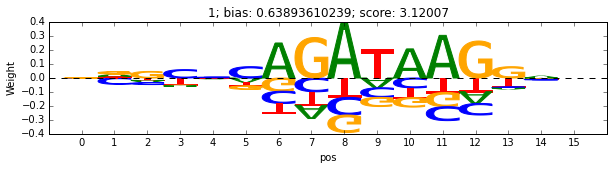

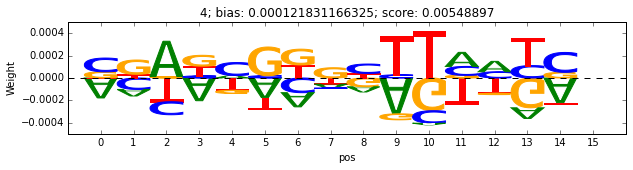

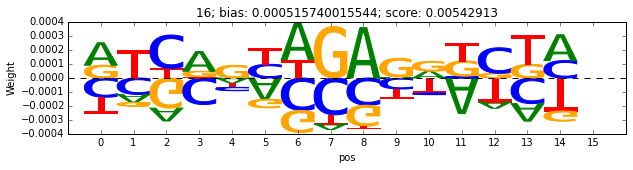

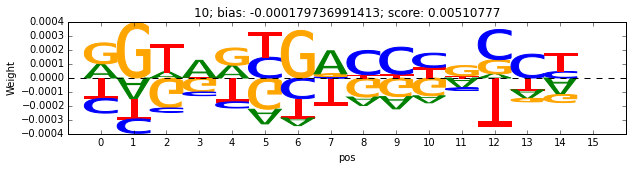

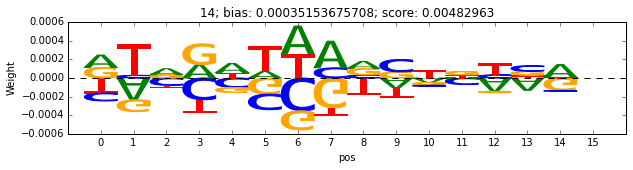

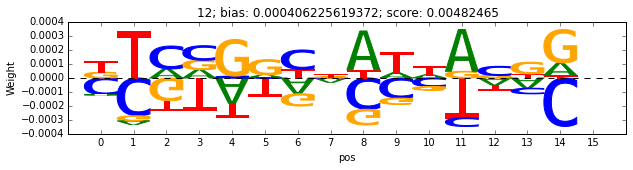

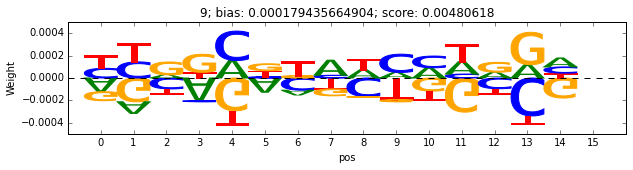

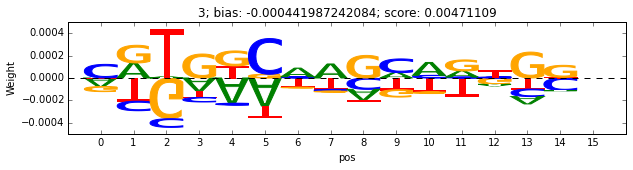

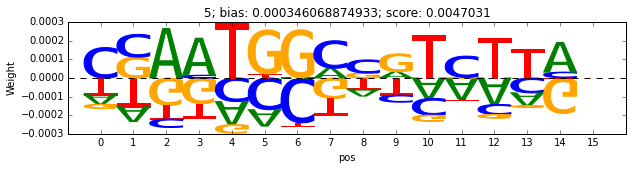

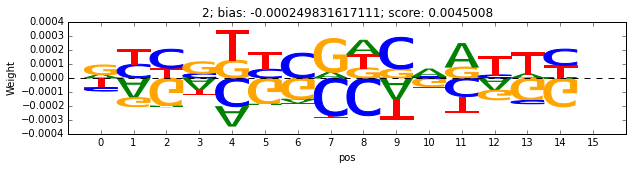

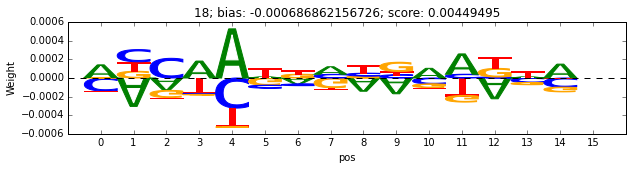

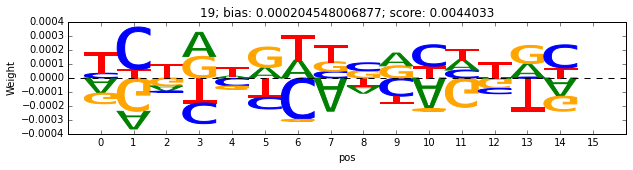

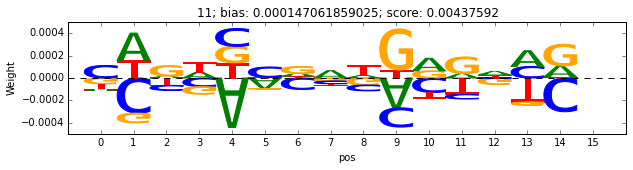

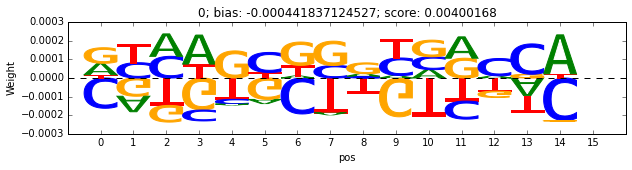

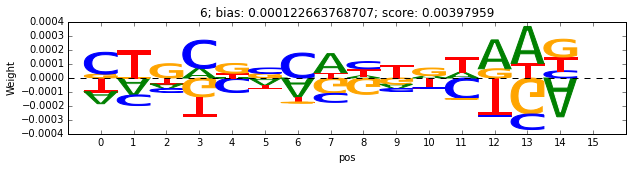

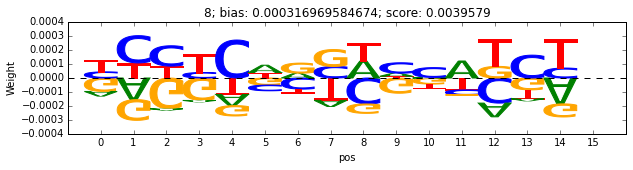

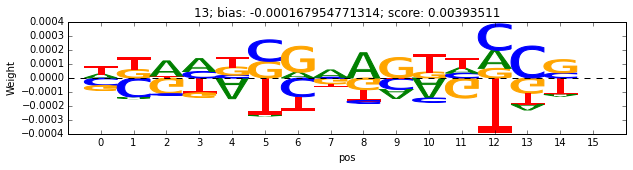

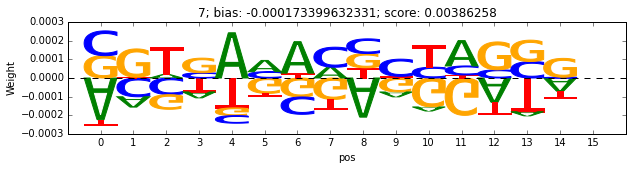

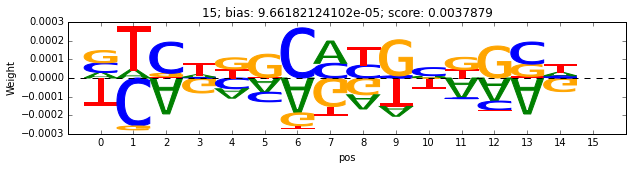

In [21]:
reconstruction_weights, reconstruction_biases = reconstruction_model.nodes['conv_deconv'].get_weights()
sortAndPrintFilters(reconstruction_weights, reconstruction_biases)

Classification model

In [ ]:
def classification_model_creator_func(nb_filter, pool_over_channels, activation):
    filter_width=20
    maxpool_filter_width=seq_length-(filter_width-1) #pool over entire region for now
    
    from keras.models import Graph
    graph = Graph() 
    graph.add_input(name="sequence", input_shape=(1,4,seq_length))
    #add convolutional layer
    graph.add_node(
        keras.layers.convolutional.Convolution2D(nb_filter=nb_filter, nb_row=4, nb_col=filter_width,
                                                 activation=activation, W_regularizer=keras.regularizers.WeightRegularizer(l1=0.00001)),
        name="conv", input="sequence")
    #add maxpool filter layer
    graph.add_node(
        keras.layers.convolutional.MaxPoolFilter2D_CenteredPool_Sequence(pool_length=maxpool_filter_width, pool_over_channels=pool_over_channels),
        name="filt", input="conv")
    #flatten
    graph.add_node(
        keras.layers.core.Flatten(),
        name="flatten", input="filt")
    #add output neuron
    graph.add_node(
        keras.layers.core.Dense(1,activation="sigmoid"),
        name="output_sigmoid", input="flatten")
    #designate output node
    graph.add_output(name="output", input="output_sigmoid")
    #compile
    graph.compile(
        optimizer=keras.optimizers.Adam(),
        loss={"output": "binary_crossentropy"}
    )
    return graph

#data loaders
classification_train_data_loader = momma_dragonn.data_loaders.core.BatchDataLoader_XYDictAPI(
                        X={'sequence': one_hot_data_train_inputs}, Y={'output': one_hot_data_train_labels_classification},
                        weight={}, batch_size=200, num_to_load_for_eval=len(one_hot_data_valid_inputs), bundle_x_and_y_in_generator=True)
classification_valid_data_loader = momma_dragonn.data_loaders.core.AtOnceDataLoader_XYDictAPI(
                        X={'sequence': one_hot_data_valid_inputs}, Y={'output': one_hot_data_valid_labels_classification})
#model evaluator
classification_model_evaluator = momma_dragonn.model_evaluators.GraphAccuracyStats(key_metric="auROC", all_metrics=["auROC"])

classification_trainer = momma_dragonn.model_trainers.keras_model_trainer.KerasFitGeneratorModelTrainer(
    samples_per_epoch=len(one_hot_data_train_inputs),
    stopping_criterion_config={"class": "EarlyStopping", "kwargs": {"max_epochs": 1000, "epochs_to_wait": 2}},
    class_weight={'output': {0: 1.0/class_imbalance, 1: 1}} #account for class imablance in class weights
)


In [ ]:
#model creator
filters_per_motif=20
classification_model_creator = momma_dragonn.model_creators.flexible_keras.KerasModelFromFunc(
    func=lambda: classification_model_creator_func(nb_filter=filters_per_motif*len(motif_names), pool_over_channels=False, activation="relu"),
    model_wrapper_class=momma_dragonn.model_wrappers.keras_model_wrappers.KerasGraphModelWrapper)
#train model
classification_model_wrapper, performance_history, training_metadata = classification_trainer.train(
                                                          model_wrapper=classification_model_creator.get_model_wrapper(),
                                                          model_evaluator=classification_model_evaluator,
                                                          valid_data_loader=classification_valid_data_loader,
                                                          other_data_loaders={'train': classification_train_data_loader},
                                                          end_of_epoch_callbacks=[]])
model = model_wrapper.model

In [ ]:
file_prefix="classification_10filtpermotif_10pcTALGATA_200bp"

In [ ]:
model_wrapper.create_files_to_save(directory="models", prefix=file_prefix)

In [ ]:
from keras.models import model_from_yaml                                    
model = model_from_yaml(open("models/"+file_prefix+"_modelYaml.yaml").read())
model.load_weights("models/"+file_prefix+"_modelWeights.h5")

In [ ]:
weights, biases = model.nodes['conv_deconv'].get_weights()
sortAndPrintFilters(weights, biases)

20 filter, pool over channels

In [ ]:
filters_per_motif=20
#model creator
model_creator = momma_dragonn.model_creators.flexible_keras.KerasModelFromFunc(
    func=lambda: model_creator_func(nb_filter=filters_per_motif*len(motif_names), pool_over_channels=True),
    model_wrapper_class=momma_dragonn.model_wrappers.keras_model_wrappers.KerasGraphModelWrapper)    
#train model
model_wrapper, performance_history, training_metadata = trainer.train(model_wrapper=model_creator.get_model_wrapper(),
                                                          model_evaluator=model_evaluator,
                                                          valid_data_loader=valid_data_loader,
                                                          other_data_loaders={'train': train_data_loader},
                                                          end_of_epoch_callbacks=end_of_epoch_callbacks)
model = model_wrapper.model

In [ ]:
file_prefix="convdeconv_20filter_10pcCTCF_45bp_centerpool_channelpool_sigmoid"

In [ ]:
model_wrapper.create_files_to_save(directory="models", prefix=file_prefix)

In [ ]:
from keras.models import model_from_yaml                                    
model = model_from_yaml(open("models/"+file_prefix+"_modelYaml.yaml").read())
model.load_weights("models/"+file_prefix+"_modelWeights.h5")

In [ ]:
weights, biases = model.nodes['conv_deconv'].get_weights()
sortAndPrintFilters(weights, biases)